<a href="https://colab.research.google.com/github/lin-k23/RISCA/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build the ADC blocks: A Programmable Analog-to-Digital Converter Array

|Name|Affiliation |IEEE Member| SSCS Member|
|:--:|:----------:|:----------:|:-------:|
|Kun Lin| Tsinghua University| No |No|
|Zhishuai Zhang (Lead)<br>zhangzs21@mails.tsinghua.edu.cn|	Tsinghua University| Yes| Yes|
|Nan Sun (Advisor)| Tsinghua University| Yes| Yes|
|Lu Jie (Advisor) |Tsinghua University |Yes |Yes|


## Abstract

This project presents a reproducible and scalable design concept for analog-to-digital converters (ADCs): the programmable ADC array (PCA). The core idea involves assembling multiple medium-performance conversion blocks into an array, with programmable control over their timing and interconnections. This modular approach allows for the formation of various structures tailored to achieve different performance specifications. The project demonstrates the high programmability and flexibility of PCA by showcasing diverse timing configurations and conducting behavioral-level simulations. These demonstrations highlight the PCA's ability to adapt to varying signal requirements, underscoring its potential for resource pooling in multi-mode signal acquisition systems.

## Introduction

There are growing diversity in mobile communication standards, and the requirements for bandwidth and accuracy of baseband signal quantization are also increasing. Designing a dedicated receiver chain for each possible signal mode requires large silicon area and high design costs. It is unsustainable as the number of signals continues to increase.

<figure>
  <img src="https://i.imgur.com/SZtnluH.png" width="400"/>
</figure>

The above problems also exist in other similar application scenarios, especially in such systems:
- There are many signal chains;
- The number of concurrent signals is uncertain;
- There are many possible signal modes and the performance varies greatly;
- The perception and quantization capabilities need to be dynamically adjusted according to the situation.

***For such multi-mode and multi-frequency receivers, resource pool is all you need!***

This project demonstrates a resource pool solution for the quantization stage, which is somewhat similar to the implementation of field programmable arrays in the realm of ADCs.

Array resources can be allocated and scheduled between different signal chains and different modes, so a high degree of resource sharing can be achieved, making the best use of limited on-chip resources.

The PCA is highly reproducible and scalable, and suitable for rapid development. With the conversion block as the basic unit, the number of blocks can be added and removed as needed, and the size of the resource pool can be tailored.


## Architecture

PCA consists of an array of multiple configuration blocks (CBs). Multiple CBs can be combined in various ways—such as time-interleaved, pipelined, or in parallel—to create different ADC configurations that address a wide range of needs.

Multiple input signals can be distributed to multiple CB samplers through a set of input buses. By configuring the input multiplexer, you can
- let one CB sample multiple signals in turn to achieve time division multiplexing;
- let multiple CBs sample different signals at the same time to achieve multitasking;
- let multiple CBs sample the same signal to suppress noise;
- let multiple CBs sample the same signal to achieve interleaving.


Considering energy efficiency and advanced process compatibility, CBs are based on SAR ADCs. The residue of SAR conversion can be
- amplified and transmitted to one of the analog buses;
- received from one of the analog buses and injected into the CDAC;
- FIR filtered for noise-shaping
It is necessary to add configurable switched capacitor circuits for residual extraction, injection, and filtering.
<figure>
  <img src="https://i.imgur.com/vppvfUc.png" width="600"/>
</figure>

The programmability of PCA is based on a description method called **timing table**.

Note that although various SAR-based hybrid architectures differ in implementation, they are fundamentally composed of three operations: sampling, conversion, and residual processing. Different architectures are essentially different combinations and sequences of these three basic operations.

So a timing table can be used to describe the working state of the PCA. Each row of the table represents a channel, and each column represents a time unit (named frame). The number of columns represents the cycle period. By specifying the behavior of each channel in each frame, the working mode of the entire array can be defined.

It is a highly open and reusable timing framework that can be filled with a variety of different instruction primitives to describe a variety of ADC architectures. For example,


|Primitive|Meaning|Example|Note|
|---------|-------|-------|-----|
|SAM[ix][F]|Sample from bus [ix], (optional) flip input|SAM0, SAM1, SAM2F|ix=0, short input; ix=1, input bus 1; ix=2, input bus 2; etc. If [ix] is omitted, SAM1 by default|
|MSB|MSB conversion (bit 1-5)|MSB| |
|LSB|LSB conversion (bit 6-11)|LSB| |
|RST|Reset SAR logic and CDAC|RST| |
|OUT[ox]|Output to output bus [ox]|OUT1, OUT2|ox=1, output bus 1; ox=2, output bus 2; etc. If [ox] is omitted, OUT1 by default|
|AMP[ax][F]|Enable residue TX and transfer residue current to analog bus [ax], (optional) flip gm input|AMP0, AMP1, AMP1F|ax=1, analog bus 1; ax=2, analog bus 2; etc.|
|F[ax][P/N][cx][L]|Enable residue RX and receive residue from analog bus [ax] to a certain capacitor [cx], positively or negatively, (optional) use low bandwidth|F1P1, F1P2, F1P12, F1P01, F1P02, F1P012, F2P2, F2N1L|cx=0, Cmajor; cx=1, Cminor1; cx=2, Cminor2; etc.|
|CHS[cx1][cx2][cx3]|Charge share between two or more caps|CHS01, CHS012|"F1P0 CHS01" is the same as "F1P1 CHS01"|
|SRT[cx1][cx2]|Short one or more bridge capacitors|SRT0, SRT01|If [cx] is omitted, SRT0 by default|


## Workflow

### Dependencies

In [87]:
import imp
from preset_mdl import preset_mdl
import preset_mdl
imp.reload(preset_mdl)
from preset_mdl import preset_mdl

from analyser.analyser_new import Analyser
import analyser.analyser_new
imp.reload(analyser.analyser_new)
from analyser.analyser_new import Analyser

In [86]:
!git clone https://github.com/lin-k23/SAR_ADC.git
import pandas as pd
import os
%cd SAR_ADC/script
from preset_mdl import preset_mdl
from preset_pr import preset_pr
from signal_source import signal_source
from RISCA_core import RISCA_core
from analyser.analyser_new import Analyser
from util.load_assembler_xlsx import load_assembler_xlsx
from util.display_dataframe import display_dataframe
from util.select import select

Cloning into 'SAR_ADC'...
remote: Enumerating objects: 589, done.
remote: Counting objects: 100% (589/589), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 589 (delta 359), reused 465 (delta 235), pack-reused 0 (from 0)
Receiving objects: 100% (589/589), 4.20 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (359/359), done.
/content/SAR_ADC/script


### Run Simulator

#### Single-Channel SAR

**Array Usage**

<figure>
  <img src="https://i.imgur.com/ZRyqsSs.png" width="600"/>
</figure>



In [90]:
mdl = preset_mdl()
pr = preset_pr()
Mode='Single-Channel SAR' # @param ['Single-Channel SAR', '3xTI-SAR', '2-stage Pipe-Sar', '1st-order NS-SAR', '1st-order NS-SAR(with chopping)','3-stage Pipe-Sar'] {type:'string'}
pr['conf_name']=select(Mode)
pr['N_fft']=8192
pr_loaded = load_assembler_xlsx(os.path.join("../config",pr['conf_name']))
pr.update(pr_loaded)
cfg_info = pd.DataFrame(pr["conf_table"])
display_dataframe(cfg_info,pr["conf_name"])

Loading file: ../config/sar/timing_table.xlsx


,Frame1,Frame2,Frame3
Item,,,
CB1,OUT RST SAM1,MSB,LSB
CB2,EMPTY,EMPTY,EMPTY
CB3,EMPTY,EMPTY,EMPTY
CB4,EMPTY,EMPTY,EMPTY
CB5,EMPTY,EMPTY,EMPTY
CB6,EMPTY,EMPTY,EMPTY


Output Spectrum


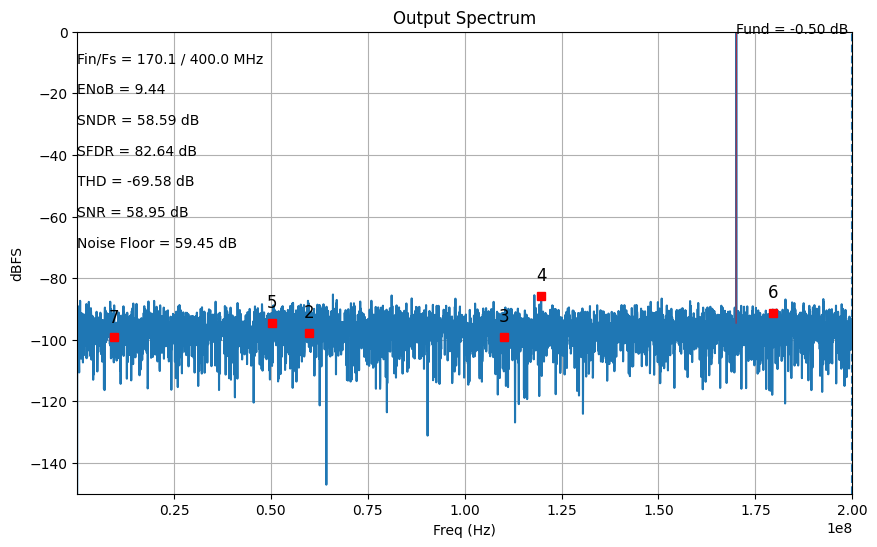

In [91]:
da = RISCA_core(mdl, pr, signal_source(pr, mdl))
test = Analyser(da, pr, mdl)
print("Output Spectrum")
test.mode_analyser()

#### 3xTI-SAR

**Array Usage**

<figure>
  <img src="https://i.imgur.com/DnGDcA5.png" width="600"/>
</figure>

In [92]:
mdl = preset_mdl()
pr = preset_pr()
Mode='3xTI-SAR' # @param ['Single-Channel SAR', '3xTI-SAR', '2-stage Pipe-Sar', '1st-order NS-SAR', '1st-order NS-SAR(with chopping)','3-stage Pipe-Sar'] {type:'string'}
pr['conf_name']=select(Mode)
pr['N_fft']=8192
pr_loaded = load_assembler_xlsx(os.path.join("../config",pr['conf_name']))
pr.update(pr_loaded)
cfg_info = pd.DataFrame(pr["conf_table"])
display_dataframe(cfg_info,pr["conf_name"])

Loading file: ../config/tisar/timing_table.xlsx


,Frame1,Frame2,Frame3
Item,,,
CB1,OUT RST SAM1,MSB,LSB
CB2,LSB,OUT RST SAM1,MSB
CB3,MSB,LSB,OUT RST SAM1
CB4,EMPTY,EMPTY,EMPTY
CB5,EMPTY,EMPTY,EMPTY
CB6,EMPTY,EMPTY,EMPTY


Output Spectrum


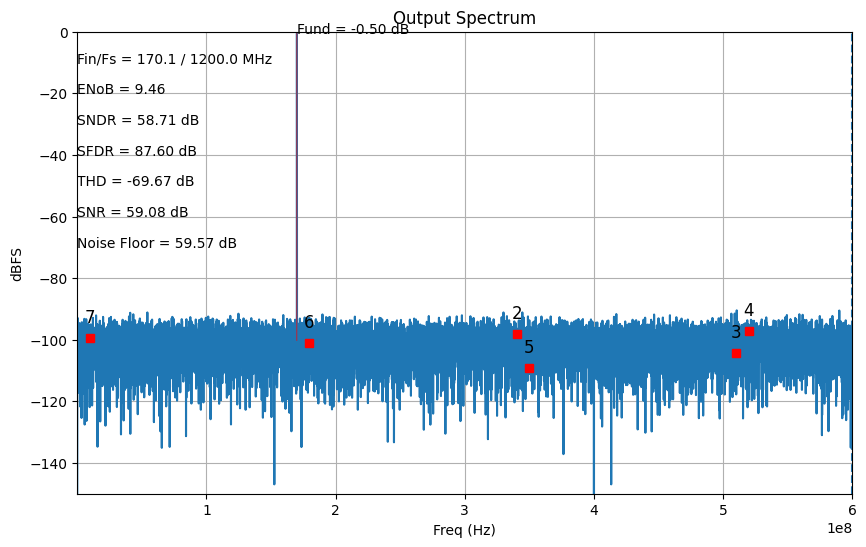

In [93]:
da = RISCA_core(mdl, pr, signal_source(pr, mdl))
print("Output Spectrum")
test = Analyser(da, pr, mdl)
test.mode_analyser()

#### 2-stage Pipe-Sar

**Array Usage**

<figure>
  <img src="https://i.imgur.com/bkj8NjW.png" width="600"/>
</figure>

In [105]:
mdl = preset_mdl()
pr = preset_pr()
Mode='2-stage Pipe-Sar' # @param ['Single-Channel SAR', '3xTI-SAR', '2-stage Pipe-Sar', '1st-order NS-SAR', '1st-order NS-SAR(with chopping)','3-stage Pipe-Sar'] {type:'string'}
pr['conf_name']=select(Mode)
pr['N_fft']=8192
pr_loaded = load_assembler_xlsx(os.path.join("../config",pr['conf_name']))
pr.update(pr_loaded)
cfg_info = pd.DataFrame(pr["conf_table"])
display_dataframe(cfg_info,pr["conf_name"])

Loading file: ../config/pipesar2s/timing_table.xlsx


,Frame1,Frame2,Frame3
Item,,,
CB1,OUT RST SAM1,MSB,AMP1
CB2,MSB,LSB,OUT RST SAM0 F1P0
CB3,EMPTY,EMPTY,EMPTY
CB4,EMPTY,EMPTY,EMPTY
CB5,EMPTY,EMPTY,EMPTY
CB6,EMPTY,EMPTY,EMPTY


Output Spectrum
12.084832396030814 74.5106910241055 97.68143999792295 74.89614084327539 -85.22015526652115 -1.045788158261138 75.94192900153652 Axes(0.125,0.11;0.775x0.77)


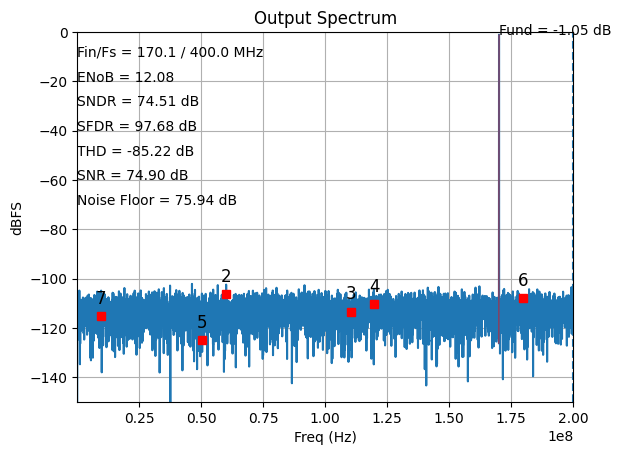

In [106]:
da = RISCA_core(mdl, pr, signal_source(pr, mdl))
print("Output Spectrum")
test = Analyser(da, pr, mdl)
test.mode_analyser()

#### 3-stage Pipe-Sar

**Array Usage**

<figure>
  <img src="https://i.imgur.com/LfVP8de.png" width="600"/>
</figure>

In [116]:
mdl = preset_mdl()
pr = preset_pr()
Mode='3-stage Pipe-Sar' # @param ['Single-Channel SAR', '3xTI-SAR', '2-stage Pipe-Sar', '1st-order NS-SAR', '1st-order NS-SAR(with chopping)','3-stage Pipe-Sar'] {type:'string'}
pr['conf_name']=select(Mode)
pr['N_fft']=4096
pr_loaded = load_assembler_xlsx(os.path.join("../config",pr['conf_name']))
pr.update(pr_loaded)
cfg_info = pd.DataFrame(pr["conf_table"])
display_dataframe(cfg_info,pr["conf_name"])

Loading file: ../config/pipesar3shp/timing_table.xlsx


,frame1,frame2,frame3,frame4,frame5
Item,,,,,
CB1,OUT RST SAM1,MSB,AMP1,AMP1,nan
CB2,AMP1,AMP1,OUT RST SAM0 F1P0,SAM0 F1P0,MSB
CB3,SAM0 F1P0,SAM0 F1P0,MSB,LSB,OUT RST
CB4,nan,nan,nan,nan,nan
CB5,nan,nan,nan,nan,nan
CB6,nan,nan,nan,nan,nan


Output Spectrum
12.699136254116198 78.20880024977951 99.32821165509573 78.5687723586856 -89.20269776125727 -1.1120818770070553 79.68085423569266 Axes(0.125,0.11;0.775x0.77)


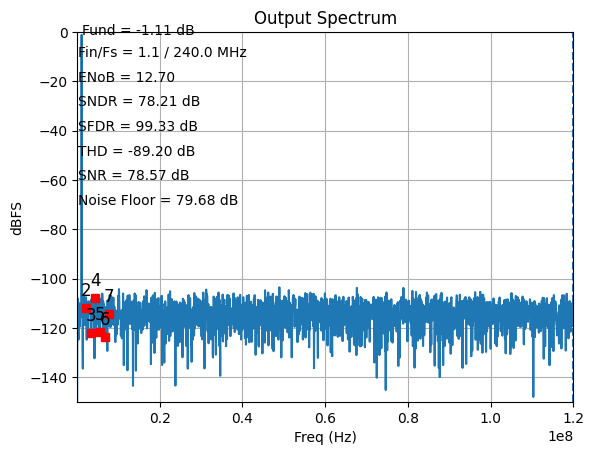

In [117]:
da = RISCA_core(mdl, pr, signal_source(pr, mdl))
print("Output Spectrum")
test = Analyser(da, pr, mdl)
test.mode_analyser()

#### 1st-order NS-SAR(with chopping)

**Array Usage**

<figure>
  <img src="https://i.imgur.com/lp6MLIP.png" width="600"/>
</figure>

In [114]:
mdl = preset_mdl()
pr = preset_pr()
Mode='1st-order NS-SAR(with chopping)' # @param ['Single-Channel SAR', '3xTI-SAR', '2-stage Pipe-Sar', '1st-order NS-SAR', '1st-order NS-SAR(with chopping)','3-stage Pipe-Sar'] {type:'string'}
pr['conf_name']=select(Mode)
pr['N_fft']=8192
pr_loaded = load_assembler_xlsx(os.path.join("../config",pr['conf_name']))
pr.update(pr_loaded)
cfg_info = pd.DataFrame(pr["conf_table"])
display_dataframe(cfg_info,pr["conf_name"])

Loading file: ../config/nssar1o1ccp/timing_table.xlsx


,Frame1,Frame2,Frame3,Frame4,Frame5,Frame6,Frame7,Frame8
Item,,,,,,,,
CB1,OUT RST RMAJ RMIN2 SAM1F,MSB CHS12,LSB,AMP0 F0N1,OUT RST RMAJ RMIN2 SAM1,MSB CHS12,LSB,AMP0 F0N1
CB2,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY
CB3,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY
CB4,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY
CB5,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY
CB6,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY,EMPTY


/content/SAR_ADC/script/util/specPlot.py:244: RuntimeWarning: divide by zero encountered in log10
  (h,) = plt.semilogx(freq, 10 * np.log10(spec))


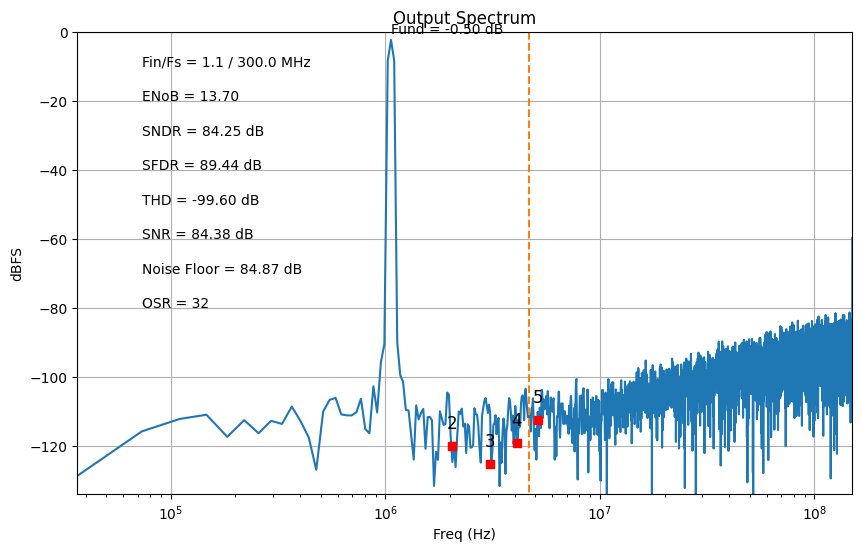

In [115]:
da = RISCA_core(mdl, pr, signal_source(pr, mdl))
test = Analyser(da, pr, mdl)
test.mode_analyser()

## Conclusion

The above code shows that PCA has strong programmability to achieve architecture combination. The simulation results of the above architectures can be summarized in the following statistical charts.

<figure>
  <img src="https://i.imgur.com/psrmnXv.png" width="400"/>
</figure>

Based on reasonable design experience, assuming that the total power consumption of each conversion module is about 2mW, the energy efficiency in each mode can be estimated.

<figure>
  <img src="https://i.imgur.com/UlhWP42.png" width="400"/>
</figure>

The above are examples of several basic structures. The template of the timing table can be summarized as follows. Other interleaving types (such as interleaved Pipeline, interleaved NS-SAR) can also be implemented. By changing the selection of input channels, time division multiplexing or multi-task concurrency can be achieved. On these basis, some auxiliary technologies and clock scaling can also be cooperated.

<figure>
  <img src="https://i.imgur.com/V0Nnzfq.jpeg" width="400"/>
</figure>

In summary, this project showcases that PCA has high field programmability, reproducibility and scalability, suitable for multi-standard applications and rapid development.